# Jupyter Notebook - Electronics Demos
This notebook demonstrates several packages that can be used to support the creation of assets relating to *electronics*.

In [24]:
%matplotlib inline

## Drawing Electrical Circuit Diagrams / Schematics

One way of using the notebooks is an an envionment to support the creation of schematic diagrams.

### `schemdraw`

The `schemdraw` package can be used to write descriptions of electrical circuit diagrams.

Examples: https://cdelker.bitbucket.io/SchemDraw/SchemDraw.html


We can parameterise values to allow us to refer to diagrams in text using similar values.

In [2]:
import SchemDraw as schem
import SchemDraw.elements as e

In [55]:
#Would be nice if we could find a way of handling units better?
#Maybe a package that gets this from value and chooses unit modifier appropriately?

R=100 * 10**3
V=10
C=0.1 * 10**-6

V_str='{V}V'.format(V=V)
R_str='{R}K$\Omega$'.format(R=R/10**3)
C_str='{C}$\mu$F'.format(C=C/10**-6)
    
d = schem.Drawing()
V1 = d.add(e.SOURCE_V, label=V_str)
d.add(e.RES, d='right', label=R_str)
d.add(e.CAP, d='down', botlabel=C_str)
d.add(e.LINE, to=V1.start);

The following circuit shows a {{print(V_str)}} source connected in series to a {{R_str}} resistor and a {{print(C_str)}} capacitor.

{{d.draw()}}

*Double click on the cell to see how the components are embedded.*

We can also update diagrams dynamically:

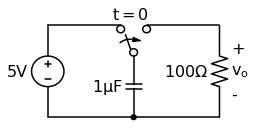

In [3]:
from ipywidgets import interact
import ipywidgets
import matplotlib.pyplot as plt

@interact(V=ipywidgets.IntSlider(min=0,max=15,step=1,value=5),
          R=ipywidgets.IntSlider(min=100,max=1500,step=100,value=100),
          C=ipywidgets.IntSlider(min=0,max=15,step=1,value=1))
def schem_demo(V, R, C, xkcdmode=False):
    if xkcdmode: plt.xkcd()
    d = schem.Drawing()
    V1 = d.add(e.SOURCE_V, label='{}V'.format(V))
    d.add(e.LINE, d='right', l=d.unit*.75)
    S1 = d.add(e.SWITCH_SPDT2_CLOSE, d='up', anchor='b', rgtlabel='$t=0$')
    d.add(e.LINE, d='right', xy=S1.c,  l=d.unit*.75)
    d.add(e.RES, d='down', label='${}\Omega$'.format(R), botlabel=['+','$v_o$','-'])
    d.add(e.LINE, to=V1.start)
    d.add(e.CAP, xy=S1.a, d='down', toy=V1.start, label='{}$\mu$F'.format(C))
    d.add(e.DOT)
    d.draw(showplot=False)

### `circuitikz`

Draw circuits using `circuitikz`.

In [4]:
%load_ext tikz_magic

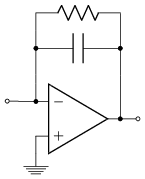

In [5]:
%%tikz -p circuitikz,gnuplottex -s 0.3
%Example circuit from: https://tex.stackexchange.com/a/379915
[every pin/.append style={align=left, text=blue}]
  \draw
  (0, 0) node[op amp] (opamp) {}
  (opamp.-) to[short,-o] (-2, 0.5)
  (opamp.-) to[short,*-] ++(0,1.5) coordinate (leftC)
            to[C]           (leftC -| opamp.out)
            to[short,-*]    (opamp.out)
            to[short,-o] ++ (0.5,0)
  (leftC)   to[short,*-] ++ (0,1)  coordinate (leftR) 
            to[R]           (leftR -| opamp.out)
            to[short,-*]    (leftC -| opamp.out)
   (opamp.+) -- ++ (0,-0.5) node[ground] {};

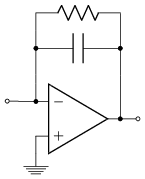

In [6]:
cct=r'''
  \draw
  (0, 0) node[op amp] (opamp) {}
  (opamp.-) to[short,-o] (-2, 0.5)
  (opamp.-) to[short,*-] ++(0,1.5) coordinate (leftC)
            to[C]           (leftC -| opamp.out)
            to[short,-*]    (opamp.out)
            to[short,-o] ++ (0.5,0)
  (leftC)   to[short,*-] ++ (0,1)  coordinate (leftR) 
            to[R]           (leftR -| opamp.out)
            to[short,-*]    (leftC -| opamp.out)
   (opamp.+) -- ++ (0,-0.5) node[ground] {};'''

%tikz -p circuitikz -s 0.3 --var cct

In [7]:
!kpsewhich bodegraph.sty 

/usr/share/texlive/texmf-dist/tex/latex/bodegraph/bodegraph.sty


In [61]:
!kpsewhich circuitikz.sty

/usr/share/texlive/texmf-dist/tex/latex/circuitikz/circuitikz.sty


## Simulating Circuits

As well as drawing circuits, there several different approaches to simulating circuit behaviour.

### Circuit Analysis - `lcapy`

`lcapy` is a linear circuit analysis package.

In [2]:
%%capture
#It seems as if lcapy, as of 7/9/18 doesn't work with current symp 1.2+
!pip install --upgrade sympy==1.1

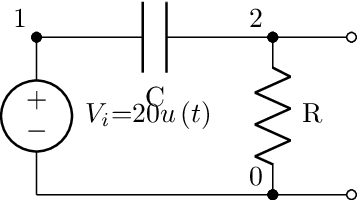

In [3]:
from lcapy import Circuit, j, omega

cct = Circuit()
cct.add("""
Vi 1 0_1 step 20; down
C 1 2; right, size=1.5
R 2 0; down
W 0_1 0; right
W 0 0_2; right, size=0.5
P1 2_2 0_2; down
W 2 2_2;right, size=0.5""")

cct.draw()

In [4]:
H = (cct.R.V('s') / cct.Vi.V('s')).simplify()
H

  C⋅R⋅s  
─────────
C⋅R⋅s + 1

In [5]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [8]:
from ipywidgets import interact

@interact(R=(1,10,1))
def response(R=1):
    cct = Circuit()

    cct.add('V 0_1 0 step 10;down')
    cct.add('L 0_1 0_2 1e-3;right')
    cct.add('C 0_2 1 1e-4;right')
    cct.add('R 1 0_4 {R};down'.format(R=R))
    cct.add('W 0_4 0; left')

    import numpy as np
    t = np.linspace(0, 0.01, 1000)
    vr = cct.R.v.evaluate(t)

    from matplotlib.pyplot import figure, savefig
    fig = figure()
    ax = fig.add_subplot(111, title='Resistor voltage (R={}$\Omega$)'.format(R))
    ax.plot(t, vr, linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Resistor voltage (V)')
    ax.grid(True)
    
    cct.draw()

A Jupyter Widget

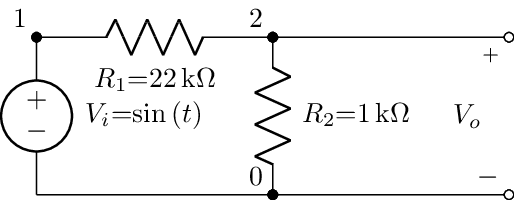

In [9]:
#Example from http://lcapy.elec.canterbury.ac.nz/schematics.html#introduction
sch='''
Vi 1 0_1 {sin(t)}; down
R1 1 2 22e3; right, size=1.5
R2 2 0 1e3; down
P1 2_2 0_2; down, v=V_{o}
W 2 2_2; right, size=1.5
W 0_1 0; right
W 0 0_2; right
'''

fn="voltageDivider.sch"
with open(fn, "w") as text_file:
    text_file.write(sch)
    
cct = Circuit(fn)
cct.draw(style='american') #american, british, european
#I wonder if we could blend the styles to make an OU style?

In [10]:
%matplotlib inline

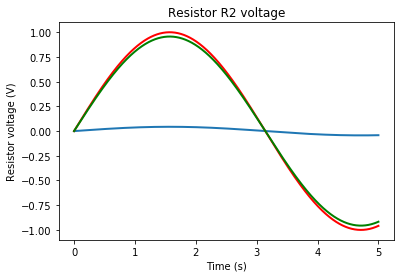

In [11]:
#How do I analyse the circuit with the ac voltage source?

import numpy as np
t = np.linspace(0, 5, 1000)
vr = cct.R2.v.evaluate(t)
from matplotlib.pyplot import figure, savefig
fig = figure()
ax = fig.add_subplot(111, title='Resistor R2 voltage')
ax.plot(t, vr, linewidth=2)
ax.plot(t, cct.Vi.v.evaluate(t), linewidth=2, color='red')
ax.plot(t, cct.R1.v.evaluate(t), linewidth=2, color='green')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Resistor voltage (V)');

In [12]:
?cct.R2.v

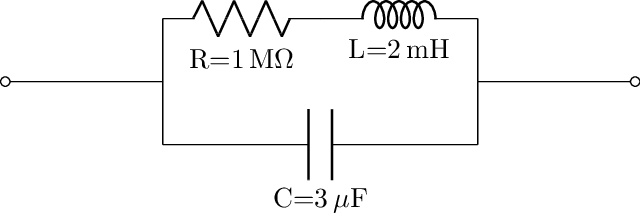

In [13]:
from lcapy import Circuit

cct = Circuit()
cct.add("""
W _0 _1; right
W _1 _2; up,size=0.4
R _2 _3 1e6; right
L _3 _4 2e-3;right
W _4 _5; down,size=0.4
W _5 _6; right
W _5 _7; down,size=0.4
C _7 _8 3e-6; left
W _8 _1; up,size=0.4
""")

cct.draw(style='british')

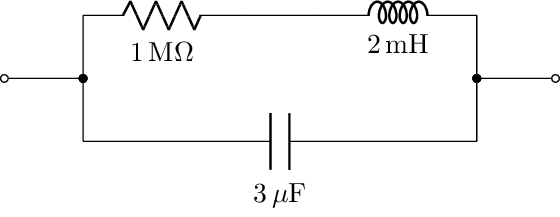

In [14]:
#alternative way of drawing circuits
from lcapy import R, C, L

cct2= (R(1e6) + L(2e-3)) | C(3e-6)
#For some reason, the style= argument is not respected
cct2.draw()

In [15]:
print(cct2.netlist())

W 1 2; right=0.5
W 2 4; up=0.4
W 3 5; up=0.4
R 4 6 1000000.0; right
W 6 7; right=0.5
L 7 5 0.002; right
W 2 8; down=0.4
W 3 9; down=0.4
C 8 9 3e-06; right
W 3 0; right=0.5


In [16]:
from lcapy import  *
from numpy import linspace
n = Vstep(20) + R(5) + C(10)
vf = linspace(0, 4, 400)
Isc = n.Isc.frequency_response().evaluate(vf)

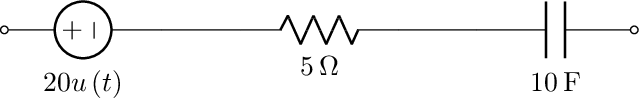

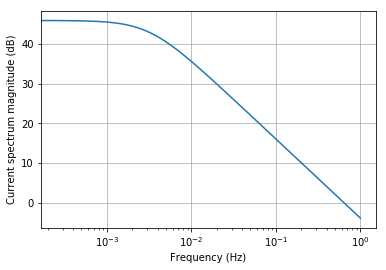

In [17]:
from numpy import logspace, linspace
from lcapy import Vstep, R, C, L

n = Vstep(20) + R(5) + C(10)
n.draw()

vf = linspace(0, 1, 4000)
n.Isc.frequency_response().plot(vf, log_scale=True);

In [18]:
from ipywidgets import interact

@interact(R1=(0.1, 10),L1=(0.01, 1),C1=(0.01,0.5))
def damping(R1=0.1,L1=0.2,C1=0.4):
    underDampedRLC = Vstep(10) + R(R1) + L(L1)+ C(C1)
    underDampedRLC.draw();

    t = linspace(0, 10, 1000)

    underDampedRLC.Isc.transient_response().plot(t);

A Jupyter Widget

In [19]:
R_1 =R('R_1')
Rtot = R_1  | R('R_2')
Rtot

R(R_1) | R(R_2)

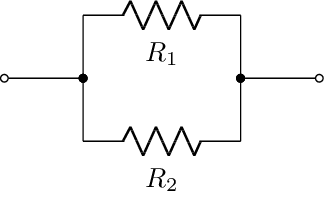

 R₁⋅R₂ 
───────
R₁ + R₂

In [20]:
from IPython.display import display, Latex

parallelR = R('R_1') | R('R_2')
parallelR.draw()

parallelR.simplify().R

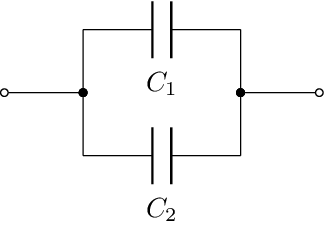

C₁ + C₂

In [21]:
parallelC = C('C_1') | C('C_2')
parallelC.draw()

parallelC.simplify().C

In [22]:
from lcapy import Vac, t, s, pi
#Representation of AC voltage source in time domain
#Vac(amplitude, phase)
Vac(20, pi/2).Voc(t)

20⋅sin(ω⋅t)

In [23]:
#Representation of AC voltage source in s domain
Vac(20).Voc(s)

  20⋅s 
───────
 2    2
ω  + s 

In [24]:
display( Latex('The overall resistance value simplifies to'+parallelR.simplify().R._repr_latex_()))

<IPython.core.display.Latex object>

In [25]:
#Transfer function
cct = Circuit()
cct.add('V1 1 0 {1}')
cct.add('R1 1 2')
cct.add('C1 2 0 C1 0')

print(cct[0].V.s)
print(cct[1].V.s)
print(cct[2].V.s)

0
1/s
1/(C_1*R_1*(s**2 + s/(C_1*R_1)))


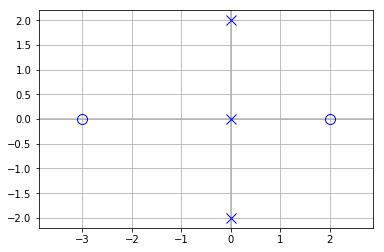

In [26]:
#pole-zero plot
from lcapy import s, j, Hs
from matplotlib.pyplot import savefig, show

H = Hs((s - 2) * (s + 3) / (s * (s - 2 * j) * (s + 2 * j)))
H.plot();

In [27]:
print( str(H) )
H

(s - 2)*(s + 3)/(s*(s - 2*j)*(s + 2*j))


   (s - 2)⋅(s + 3)   
─────────────────────
s⋅(s - 2⋅j)⋅(s + 2⋅j)

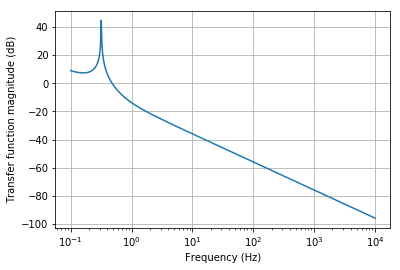

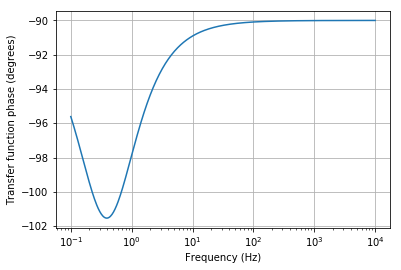

In [28]:
#bode - just does the amplitude response?
from lcapy import s, j, pi, f, Hs
from numpy import logspace
import matplotlib.pyplot as plt

H = Hs((s - 2) * (s + 3) / (s * (s - 2 * j) * (s + 2 * j)))

A = H(j * 2 * pi * f)

fv = logspace(-1, 4, 400)
A.plot(fv, log_scale=True)
A.phase_degrees.plot(fv,log_scale=True);

## `control`

Pyhton [control systems library](https://python-control.readthedocs.io/en/0.8.0/index.html).

Can be used for a wide range of control applications and chart generation.

In [1]:
%matplotlib inline

In [2]:
import control
#State space system definition
sys=control.ss("1. -2; 3. -4", "5.; 7", "6. 8", "9.")

#It would be nice if we could print the sys diagram as LaTeX styled matrices?
sys

A = [[ 1. -2.]
 [ 3. -4.]]

B = [[5.]
 [7.]]

C = [[6. 8.]]

D = [[9.]]

In [17]:
sys.A

matrix([[ 1., -2.],
        [ 3., -4.]])

In [25]:
#https://stackoverflow.com/a/17131750/454773

#Note that https://pypi.org/project/PyLaTeX/ may also be generally handy???
import numpy as np

def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

from IPython.display import display,Latex
display(Latex(bmatrix(sys.A)))
display(Latex(bmatrix(sys.B)))
display(Latex(bmatrix(sys.C)))
display(Latex(bmatrix(sys.D)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In the `control` diagrams below, `**kwargs` can be passed in to style the matplotlib figure further. It would be handy if could get access the the figure object too? The plotting routines themselves are in [`control/freqplot.py`](https://github.com/python-control/python-control/blob/master/control/freqplot.py).

### Nyquist diagrams

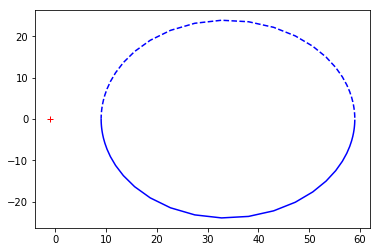

In [10]:
real, imag, freq = control.nyquist_plot(sys, omega=None, Plot=True, color='b', labelFreq=0)

### Bode plots

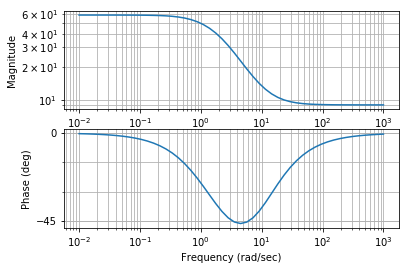

In [8]:
#sys = ss("1. -2; 3. -4", "5.; 7", "6. 8", "9.")
mag, phase, omega = control.bode(sys)

## *Circuit Sandbox*

The [Circuit Sandbox](https://github.com/willymcallister/circuit-sandbox) is a simple, standalone Javascript circuit simulator that we can embed in a notebook or [run in its own browser tab](js/circuit-sandbox-master/index.html).

The *Circuit Sandbox* can save and load simple netlists (*I don't know if these can then be used by other packages?*)

In [63]:
from IPython.display import IFrame
IFrame('js/circuit-sandbox-master/index-mobile.html', width=1000,height=600)

## Digital Circuit Simulator

`simcirjs` [[docs](https://github.com/kazuhikoarase/simcirjs)) is a syandalone Javascript digital circuit simulator that we can embed in a notebook or [run in its own browser tab](js/simcirjs-master/sample.html).

In [64]:
#!ls js/simcirjs-master/
from IPython.display import IFrame
IFrame('js/simcirjs-master/blank.html', width=600,height=300)

### `ahkab`

[`ahkab`](https://ahkab.readthedocs.io/en/latest/index.html) is an open-source SPICE-like interactive circuit simulator.

*Unfortunately, it doesn't render the schematic diagram from the circuit description. It would be useful if we `ahkab` could work with something like `schemdraw` to support such a dual behaviour from the same circuit descrpition.*

The examples below are based on the original documentation.

In [65]:
import ahkab

In [66]:
cct = ahkab.Circuit('Simple Example Circuit')

cct.add_resistor('R1', 'n1', cct.gnd, value=5)
cct.add_vsource('V1', 'n2', 'n1', dc_value=8)
cct.add_resistor('R2', 'n2', cct.gnd, value=2)
cct.add_vsource('V2', 'n3', 'n2', dc_value=4)
cct.add_resistor('R3', 'n3', cct.gnd, value=4)
cct.add_resistor('R4', 'n3', 'n4', value=1)
cct.add_vsource('V3', 'n4', cct.gnd, dc_value=10)
cct.add_resistor('R5', 'n2', 'n4', value=4)

opa = ahkab.new_op()
r = ahkab.run(cct, opa)['op']
print(r)

OP simulation results for 'Simple Example Circuit'.
Run on 2017-12-08 22:28:25, data file /tmp/tmp_k1yz97v.op.
Variable    Units        Value         Error    %
----------  -------  ---------  ------------  ---
VN1         V        -3.86364    3.86358e-12    0
VN2         V         4.13636   -4.13591e-12    0
VN3         V         8.13636   -8.13602e-12    0
VN4         V        10         -1.00027e-11    0
I(V1)       A        -0.772727   0              0
I(V2)       A        -0.170455   0              0
I(V3)       A        -3.32955    0              0


## Boolean Algebra - `PyEDA`

`PyEDA` is a [Python package for exploring Boolean algebra](http://pyeda.readthedocs.io/en/latest/boolalg.html).

In [67]:
from pyeda.inter import *

A = exprvar('A')
B = exprvar('B')
C = exprvar('C')

In [68]:
A & B

And(A, B)

In [69]:
A & ~B

And(A, ~B)

In [70]:
(A | B) & C

And(Or(A, B), C)

In [71]:
A ^ B

Xor(A, B)

In [72]:
expr2truthtable(A & ~B)

B A
0 0 : 0
0 1 : 1
1 0 : 0
1 1 : 0

In [73]:
expr2truthtable( Or(And(A, B), And(A, C)) )

C B A
0 0 0 : 0
0 0 1 : 0
0 1 0 : 0
0 1 1 : 1
1 0 0 : 0
1 0 1 : 1
1 1 0 : 0
1 1 1 : 1

In [74]:
expr2truthtable( And('X', 'Y') )

Y X
0 0 : 0
0 1 : 0
1 0 : 0
1 1 : 1

In [75]:
tt = truthtable(reversed([A,B,C]), "00010111")
tt

A B C
0 0 0 : 0
0 0 1 : 0
0 1 0 : 0
0 1 1 : 1
1 0 0 : 0
1 0 1 : 1
1 1 0 : 1
1 1 1 : 1

In [76]:
truthtable2expr( tt ) 

Or(And(~A, B, C), And(A, ~B, C), And(A, B, ~C), And(A, B, C))